In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pims
import fsvpy as fsv
import pandas as pd
from pandas import DataFrame, Series
from scipy.optimize import curve_fit
import os.path
from scipy.optimize import OptimizeWarning
import warnings

In [19]:
#catch optimize error warnings
with warnings.catch_warnings():
    warnings.simplefilter("error", OptimizeWarning)

In [20]:
@pims.pipeline
def conv_grey(frame):
    one_channel = frame[:,:,1]
    return one_channel

#change tiff stack here ------>
frames = pims.open('/Volumes/LAB_AKALANKA/March2024/2024_03_27/Flow_edge2/*.tif')

singleFrame =False
needplot = False
frame = 23 #frame to show
diameter = 3 #um
Resl = 325 # nm per pixel (20x with 1x)


if needplot ==True:
    plt.imshow(frames[frame], cmap = 'Greys_r')
#frames= frames[13]

In [21]:
#define arrays to store var

temp =[] #stores width
temp_h=[] # stores height
centerx = []
centery =[]
total_streaks_list=[]


In [22]:

#frames.shape[0]----- copy this in for loop for many frames i. e. singleFrame = False
# (frame,frame+1,1) ---- copy this in loop for a single frame i.e. singleFrame = True
for j in range(frames.shape[0]):

    if j%100 ==0:
        print(f'{j}processes completed....')

    
    image = frames[j]    
    contours, preprocessed_img = fsv.locate_streaks(image)
    #Now .locate streaks does the preprocess step, detects contours and returns it!   
    streak_properties = fsv.parameters(contours)
    # .parameters analyzes the contours detected, checks for the closed contours, and returns a PD containing contour properties( area, angle etc)
    #streak_properties= streak_properties.dropna()
    # drops any NaN's in the dataframe
    filtered_streaks= fsv.filter(streak_properties)
    # .filter enforces min_height, min_aspect ratio and an edge filter to remove unwanted streaks
    # returns the filtered data frame
    #filtered_streaks=filtered_streaks.dropna()
    # just a caution- drops any Nan's
    fitted_streaks= fsv.fit_shape(image, filtered_streaks,diameter,Resl)
    # extract the width, height of the streaks by fitting to gaussians!
    # This will work ok for in-plane streaks
    # Need another way to fit for off-plane streaks, as they necessarily don't follow gaussian profiles'
    # Returns the final pandas dataframe with all the streak parameters

    if len(np.asarray(fitted_streaks['width'])) !=0:
        temp.append(np.asarray(fitted_streaks['width']))
        temp_h.append(np.asarray(fitted_streaks['height']))
        centerx.append(np.asarray(fitted_streaks['x']))
        centery.append(np.asarray(fitted_streaks['y'])) #these are actually redundant now
        #add centers of the streak
        #append everything to a central dataframe
        for idx, row in fitted_streaks.iterrows():

            total_streaks_list.append([row.frame, row.x, row.y, row.corner_x, row.corner_y, row.bbox_width, row.bbox_height, row.angle, row.width, row.height])

        total_streaks = pd.DataFrame(data=np.array(total_streaks_list), columns = ['frame','x','y','corner_x', 'corner_y',
                                                                                                                         'bbox_width', 'bbox_height', 'angle','width', 'height'])
    else:
        pass

    #save total_streaks to csv for good visualization
    total_streaks.to_csv('Total_streaks')

 

0processes completed....
Rejected streak -- Optimization warning- measure.py_line 319
 Detected an open contour
 Detected an open contour
 Detected an open contour
Entered except block (bad fit) - measure.py_line 178
Rejected streak -- Optimization warning- measure.py_line 319
 Detected an open contour
 Detected an open contour
Rejected streak -- Optimization warning- measure.py_line 319
Rejected streak -- Optimization warning- measure.py_line 319
 Detected an open contour
 Detected an open contour
 Detected an open contour
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit) - measure.py_line 178
 except block measure.py- line 174
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit)- measure.py_line 183
 except block measure.py- line 174
Entered except block (bad fit) - measure.py_line 178
Entered except block (bad fit)- measure.py_line 183
Rejected streak -- Optimization warning- measure.py_line 319
 Detected an open conto

In [23]:
if singleFrame:
    # We need to look at athe original contours detected in the frame
    fsv.plot_contours(frames[frame],contours)
    #fig, ax = plt.subplots()
    #ax.imshow(preprocessed_img, cmap='Greys_r')
    #ax.set_title('Pre-processed image');
    #fsv.plot_fit(image,filtered_streaks)
    # fit and plot the streaks
    fsv.plot_fit(image, fitted_streaks)


In [24]:
#Input imaging parameters
Resl = 325 # nm per pixel (20x with 1x)
Exposure = 90 # in ms
Flow_rate = 60 # in uLpermin

#Filter out the NaN's coming from null tags
true_width = []
true_height= []
true_centerx = []
true_centery = []
#convert from list to array
for iter in range(len(temp)):
    for i in range(int(temp[iter].shape[0])):
         true_width.append(temp[iter][i])
         true_height.append(temp_h[iter][i])
         true_centerx.append(centerx[iter][i])
         true_centery.append(centery[iter][i])

#scale widths by resolution        
true_width = np.asarray(true_width)* (Resl/((Exposure/1000)))/1000000 # in mm/s i.e the velocity
true_height = np.asarray(true_height)* (Resl/1000) #in um, basically should equal particle diameter 
true_centerx = np.asarray(true_centerx)* (Resl/1000)
true_centery = np.asarray(true_centery)* (Resl/1000)


In [25]:
#Get only inplane streaks from the total streaks data frame

diameter = 3 #um

inplane_streaks = fsv.plane_filter(total_streaks, diameter, Resl, True)


diameter = 8#um

inplane_streaks2 = fsv.plane_filter(total_streaks, diameter, Resl, True)

diameter = 13 #um

inplane_streaks3 = fsv.plane_filter(total_streaks, diameter, Resl, True)

Text(0, 0.5, 'Count')

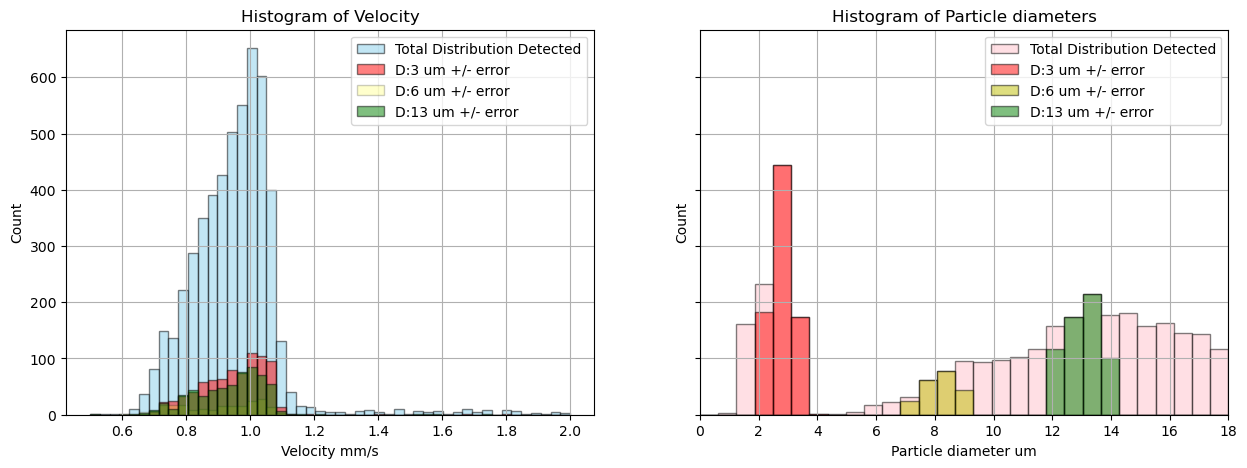

In [26]:

fig, ax = plt.subplots(ncols=2, sharey = True, figsize=(15,5))
bins = np.linspace(0.5, 2, 50)
ax[0].hist(true_width, bins, color='skyblue', edgecolor='black', alpha=0.5, label='Total Distribution Detected');
ax[0].hist(np.asarray(inplane_streaks.width)*((Resl/((Exposure/1000)))/1000000), bins, color='red', edgecolor='black', alpha=0.5, label = 'D:'+str(3)+' um +/- error');
ax[0].hist(np.asarray(inplane_streaks2.width)*((Resl/((Exposure/1000)))/1000000), bins, color='yellow', edgecolor='black', alpha=0.2, label = 'D:'+str(6)+' um +/- error');
ax[0].hist(np.asarray(inplane_streaks3.width)*((Resl/((Exposure/1000)))/1000000), bins, color='green', edgecolor='black', alpha=0.5, label = 'D:'+str(diameter)+' um +/- error');
ax[0].set_title('Histogram of Velocity')
ax[0].set_xlabel('Velocity mm/s')
ax[0].set_ylabel('Count')
ax[0].legend(loc='upper right')
#ax[0].set_xlim([0.12, 0.16])
ax[0].grid()

bins = np.linspace(0, 18, 30)
ax[1].hist(true_height, bins, color='pink', edgecolor='black', alpha=0.5, label='Total Distribution Detected');
ax[1].hist(np.asarray(inplane_streaks.height)*(Resl/1000), bins, color='red', edgecolor='black', alpha=0.5, label = 'D:'+str(3)+' um +/- error');
ax[1].hist(np.asarray(inplane_streaks2.height)*(Resl/1000), bins, color='y', edgecolor='black', alpha=0.5, label = 'D:'+str(6)+' um +/- error');
ax[1].hist(np.asarray(inplane_streaks3.height)*(Resl/1000), bins, color='g', edgecolor='black', alpha=0.5, label = 'D:'+str(diameter)+' um +/- error');
ax[1].set_xlim([0, 18])
ax[1].set_title('Histogram of Particle diameters')
ax[1].grid()
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Particle diameter um')
ax[1].set_ylabel('Count')

#plot the inplane streaks to get the filtered distribution





Now just proceed to plot the vector fields...

In [27]:
# average rows 
# i.e. if upper left corner is (0,0) & down is X, right is Y
# average all Y in a particular x

Real_FOV  = 2048 * (Resl/1000)  # 2048 is image size mostly fixed for camera
binsize = 20 # um values

d = {'x': true_centerx, 'y': true_centery, 'velocity': true_width, 'diameter': true_height}


all_properties = pd.DataFrame(data = d)


# sort data frame ascending in x
all_properties = all_properties.sort_values(by='x', ascending=True)


Plot the velocity field as a interpolation

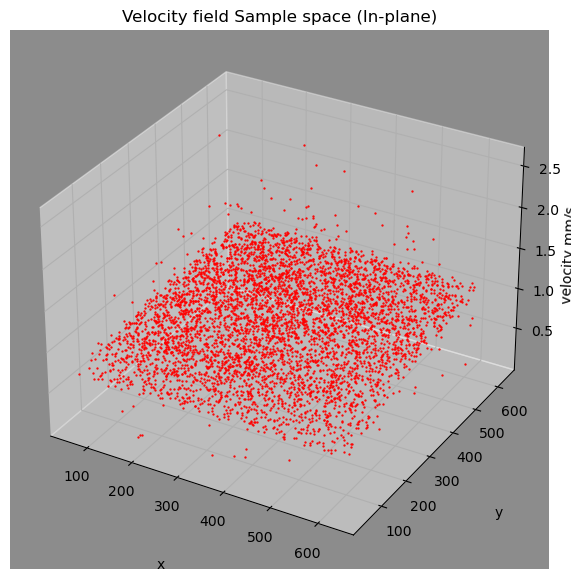

In [28]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
#create mesh
X1, Y1 = np.meshgrid(true_centerx,true_centery)


ax.plot3D(true_centerx, true_centery, true_width,'r.',markersize=1.3)
ax.set_title('Velocity field Sample space (In-plane)')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('velocity mm/s', labelpad=1)
ax.set_facecolor('#8c8c8c')
plt.show()


Averaging is not the best option to plot velocity (?)

In [29]:
# Average velocities according to bin size = []
vx = []
xpos=[]
precision = 1 # um steps size for vector plot

for i in range(0,int(Real_FOV),binsize):
    start = i
    end = (i + binsize)

    df_1 = all_properties[(all_properties['x'] >= start) & (all_properties['x'] <= end)]

    if (df_1.empty):
        #d_2 = {'x': np.linspace(start,end,binsize+1), 'velocity':  np.zeros(binsize+1)}
        x = np.linspace(start,end,binsize+1)
        velocity = np.zeros(binsize+1)
    else:
        
        xmean  = df_1['velocity'].mean()
        x = np.linspace(start,end,binsize+1)
        velocity =  xmean * np.ones(binsize+1)
        #d_2 = {'x': np.linspace(start,end,binsize+1), 'velocity': xmean * np.ones(binsize+1)}
    
    #append to final df
    #df_2 = pd.DataFrame(data = d_2)
    for j in range(binsize):
        vx.append(velocity[j])
        xpos.append(x[j])

    d2 = {'x': xpos, 'velocity': vx}
    velocityfield = pd.DataFrame(data = d2)




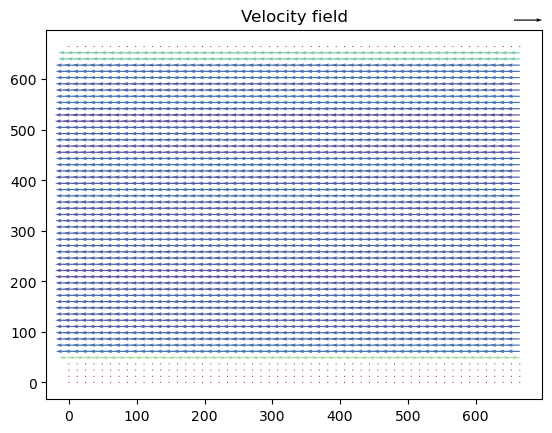

In [30]:
#plot the vector field / Quiver plot
#create a meshgrid
scale=12
X, Y = np.meshgrid(np.linspace(0, int(Real_FOV),int(Real_FOV/scale) ), np.linspace(0, int(Real_FOV),int(Real_FOV/scale) ))

U = np.zeros([int(Real_FOV/scale),int(Real_FOV/scale)])
for i in range(0,int(Real_FOV/scale)-1,1):
    U[i,:] = vx[i*scale]+ U[i,:]

V = np.zeros([int(Real_FOV/scale),int(Real_FOV/scale)])
fig1, ax1 = plt.subplots()
ax1.set_title('Velocity field')
Q = ax1.quiver(X, Y, -U,V,U,cmap="Spectral", scale=35, units='width')
qk = ax1.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')
